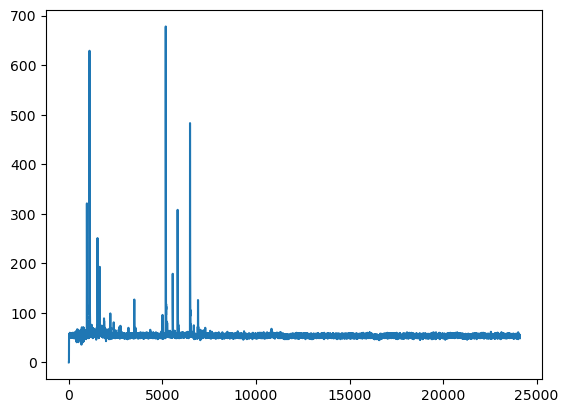

In [15]:
import matplotlib.pyplot as plt
f = open("../Output/MuSR/output_f10238c8_raw.csv")
vals = [l.split(",") for l in f.readlines()[0:]]
x = [float(v[0]) for v in vals]
y = [float(v[1]) for v in vals]

plt.plot(x,y)


In [37]:
from typing import Any, List
import h5py as hp
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def test_monotonic_increasing(sequence):
    array = np.array([0 for _ in range(len(sequence))])
    sequence.read_direct(array)
    diff = np.diff(array)

    print(f"   |num non-monotonic elements = {len(diff[diff < 0])}")

def test_uniqueness(sequence):
    array = np.array([0 for _ in range(len(sequence))])
    sequence.read_direct(array)
    unique_values = np.unique(array)

    print(f"   |num duplicate elements found = {len(array) - len(unique_values)}")

def test_outliers(sequence, expected_diff):
    array = np.array([0 for _ in range(len(sequence))])
    sequence.read_direct(array)
    num_outliers = np.count_nonzero(array > 2*len(array)*expected_diff)
    print(f"   |num outliers (i.e. greater than 2*{len(array)*expected_diff}) = {num_outliers}")
    #if len(outliers) > 0:
    #    print(f"   |   outlier values = {len(outliers)}")

def test_distribution(sequence, num_channels):
    array = np.array([0 for _ in range(len(sequence))])
    sequence.read_direct(array)
    distr = np.array([np.count_nonzero(array == c) for c in range(num_channels)])
    if np.any(distr == 0):
        print(f"   |num channels with zero events = {np.count_nonzero(distr == 0)}")


    

In [51]:

def test_duplicate_events(time_zero, indices, events):
    time_zero_array = np.array([0 for _ in range(len(time_zero))])
    time_zero.read_direct(time_zero_array)
    events_lists = chop_events(indices, events)
    if len(time_zero_array) != len(events_lists):
        print("Events lists fuckt")

    unique_values, inverse, counts = np.unique(time_zero_array, return_counts = True, return_inverse = True)
    for idx, uv in enumerate(unique_values):
        if counts[idx] > 1:
            indices = [i for i,_ in enumerate(inverse == uv)]
            lists = [events_lists[i] for i in indices]
            if np.all([lists[0] == l for l in lists[1:]]):
                pass #print("   |Duplicates, are really duplicates")
            else:
                print("   |Duplicates, are not really duplicates")


def chop_events(indices, events) -> List[Any]:
    index_array = np.array([0 for _ in range(len(indices) + 1)])
    indices.read_direct(index_array[:-1])
    events_array = np.array([0 for _ in range(len(events))])
    events.read_direct(events_array)
    index_array[-1] = len(events_array)
    return [events_array[i1:i2] for (i1,i2) in sliding_window_view(index_array, window_shape = 2)]


def assess_file(file: hp.File):
    start_time = file.get("/raw_data_1/start_time")
    end_time = file.get("/raw_data_1/end_time")
    event_id = file.get("/raw_data_1/detector_1/event_id")
    event_time_zero = file.get("/raw_data_1/detector_1/event_time_zero")
    event_index = file.get("/raw_data_1/detector_1/event_index")

    print(f"frame {f}:")

    print(f"  start = {start_time.values()}")
    val = end_time.get()
    print(f"  start = {val}")
    print(f"  end = {event_time_zero.len()}")
    print(f"  num frames = {event_time_zero.len()}")
    if event_time_zero.len() != 0:
        test_monotonic_increasing(event_time_zero)
        test_uniqueness(event_time_zero)
        test_outliers(event_time_zero, 20000000)
    
    print(f"  num events = {len(event_id)}")
    #test_duplicate_events(event_time_zero,event_index,event_id)
    test_distribution(event_id, 64)


In [52]:
f1,f2 = 4911,5536
path = "../archive/incoming/hifi/HIFI0000"

for f in range(f1,f2):
    try:
        file = hp.File(f"{path}{f}.nxs")
        assess_file(file)
    except ZeroDivisionError as e:
        print(f"{e}")
    except FileNotFoundError as e:
        print(f"{e}")

frame 4911:


AttributeError: 'Dataset' object has no attribute 'values'

In [3]:
import pandas as pd

headers = ["time_written", "time_logged", "kafka_ms", "digitiser_id", "num_frames_cached", "timestamp_of_latest_frame_send", "digitiser_eventlist_timestamp"]
dtypes = {"time_written": "int", "time_logged": "int", "kafka_ms": "int", "digitiser_id": "int", "num_frames_cached": "int", "timestamp_of_latest_frame_send": "int", "digitiser_eventlist_timestamp": "int"}
date_cols = ["time_written", "time_logged", "timestamp_of_latest_frame_send", "digitiser_eventlist_timestamp"]
df = pd.read_csv("../LogAnalysis/temp3", header=None, names = headers, dtype = dtypes, parse_dates=date_cols)

df.tail()

,time_written,time_logged,kafka_ms,digitiser_id,num_frames_cached,timestamp_of_latest_frame_send,digitiser_eventlist_timestamp
186744,2025-01-24 16:23:11.987682631,2025-01-24 16:23:11.987628,1737735791980,4,83,2025-01-24 16:23:09.565536820,2025-01-24 16:23:09.620082020
186745,2025-01-24 16:23:11.992460010,2025-01-24 16:23:11.992390,1737735791989,4,83,2025-01-24 16:23:09.583718540,2025-01-24 16:23:09.620082020
186746,2025-01-24 16:23:11.992579655,2025-01-24 16:23:11.992561,1737735791989,9,83,2025-01-24 16:23:09.565536820,2025-01-24 16:23:09.620082020
186747,2025-01-24 16:23:12.008908059,2025-01-24 16:23:12.008881,1737735792003,9,83,2025-01-24 16:23:09.583718540,2025-01-24 16:23:09.620082020
186748,2025-01-24 16:23:12.154214724,2025-01-24 16:23:12.154147,1737735792146,9,74,2025-01-24 16:23:09.765535860,2025-01-24 16:23:09.783717600


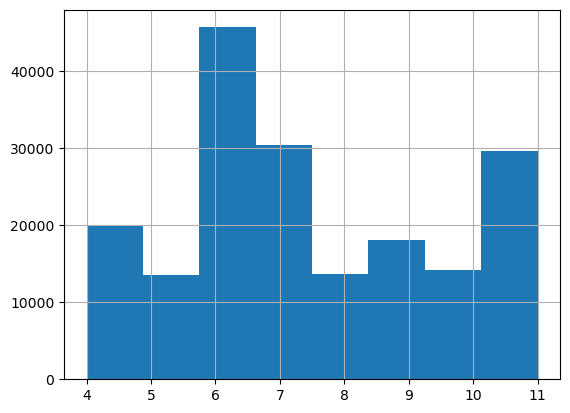

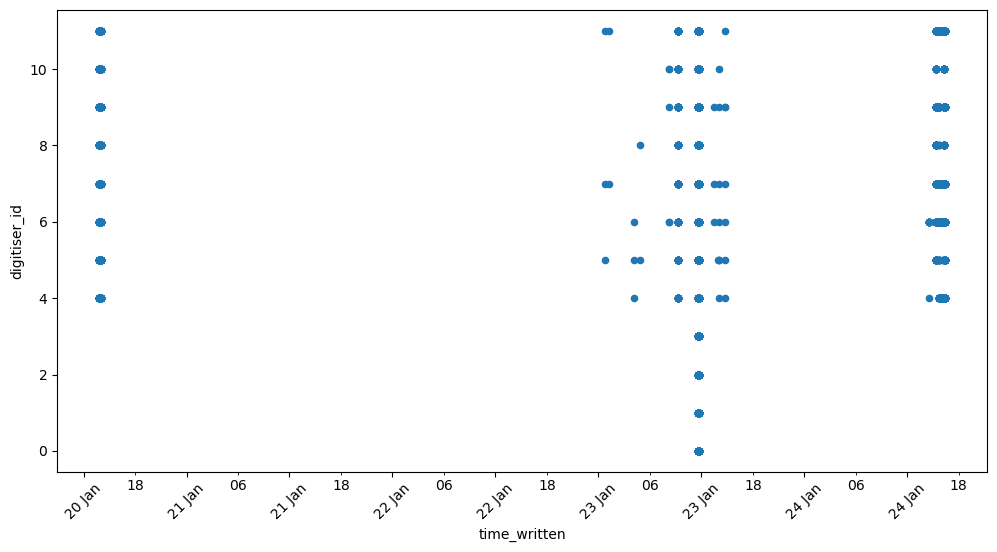

In [4]:
import matplotlib.dates as mdates

ax = df[df["digitiser_id"] > 3]["digitiser_id"].hist(bins=8)
ax = df.plot.scatter(x = "time_written", y = "digitiser_id", rot=45, figsize = (12,6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d Jan"))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour = [0,6,12,18]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))


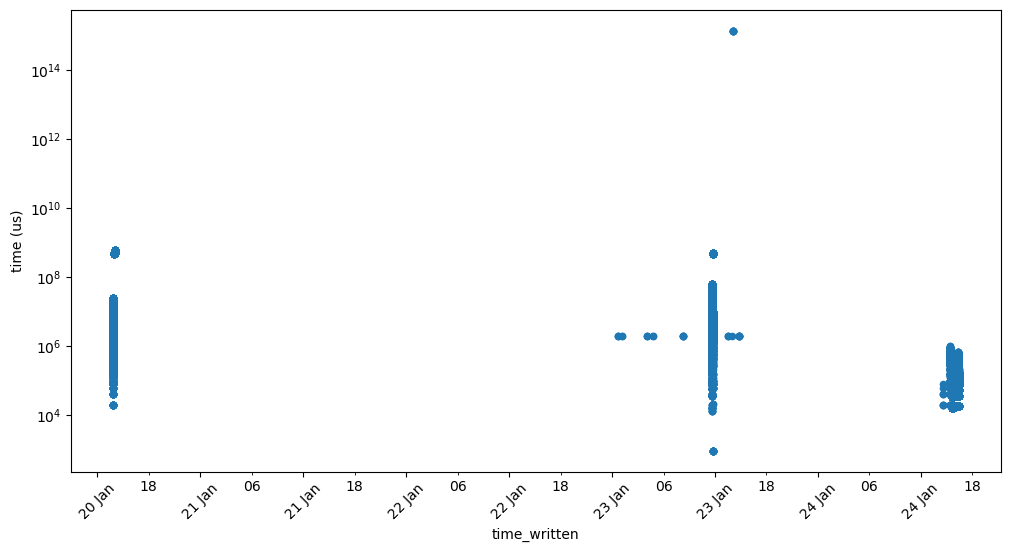

In [5]:
from datetime import timedelta
df["diff"] = (df["digitiser_eventlist_timestamp"] - df["timestamp_of_latest_frame_send"]).apply(lambda x: x/timedelta(microseconds=1))
ax = df.plot.scatter(x = "time_written", y = "diff", logy=True, ylabel="time (us)", figsize = (12,6), rot = 45)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d Jan"))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour = [0,6,12,18]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

<Axes: xlabel='digitiser_eventlist_timestamp', ylabel='kafka_ms'>

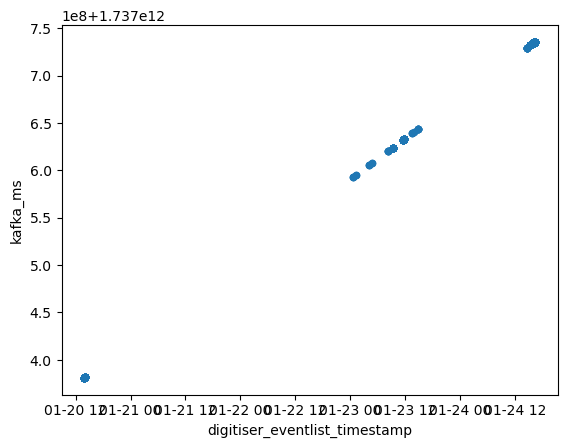

In [19]:
df_max = df["digitiser_eventlist_timestamp"].max()
df_temp = df[df["digitiser_eventlist_timestamp"] != df_max]
df_temp.plot.scatter(x = "digitiser_eventlist_timestamp", y = "kafka_ms")